In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
file_path = 'Zipline_Systems_Engineering_Data_Analyst_Takehome_Test.xlsx'
failed_flight_data = pd.read_excel(file_path, sheet_name='Failed Flight Data')

In [4]:
# Display initial summary
print("Initial Dataset Information:")
print(failed_flight_data.info())
print("\nSample Data:")
print(failed_flight_data.head())

Initial Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   flight_elapsed_time_s  2501 non-null   float64
 1   aircraft_id            2501 non-null   object 
 2   wind_speed_mps         2501 non-null   float64
 3   motor_1_temperature_c  2501 non-null   float64
 4   motor_2_temperature_c  2250 non-null   float64
 5   active_alarm           251 non-null    object 
dtypes: float64(4), object(2)
memory usage: 117.4+ KB
None

Sample Data:
   flight_elapsed_time_s aircraft_id  wind_speed_mps  motor_1_temperature_c  \
0                    0.0  p2-zip-xyz        0.944912              30.057061   
1                    0.2  p2-zip-xyz        0.969748              30.096818   
2                    0.4  p2-zip-xyz        0.962835              29.966869   
3                    0.6  p2-zip-xyz        0.995219        

In [5]:
# Handle missing values
# Interpolate missing motor_2_temperature_c values
failed_flight_data['motor_2_temperature_c'] = failed_flight_data['motor_2_temperature_c'].interpolate()

In [6]:
# Keep active_alarm as-is. Missing values indicate no alarms were triggered 

In [7]:
# Ensure time-series is sorted by elapsed time
failed_flight_data = failed_flight_data.sort_values(by='flight_elapsed_time_s')

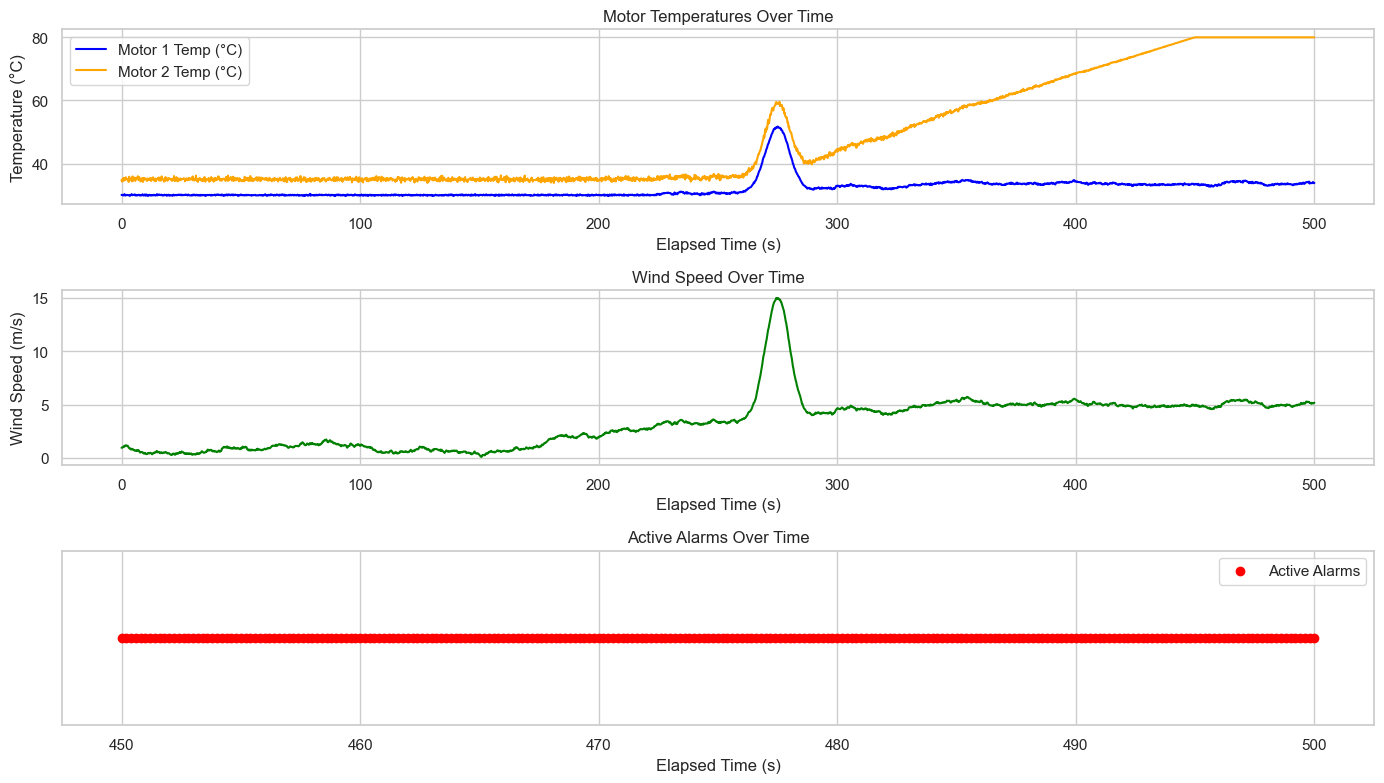

In [8]:
# Visualize key metrics
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))

# Plot Motor Temperatures
plt.subplot(3, 1, 1)
plt.plot(failed_flight_data['flight_elapsed_time_s'], failed_flight_data['motor_1_temperature_c'], label='Motor 1 Temp (°C)', color='blue')
plt.plot(failed_flight_data['flight_elapsed_time_s'], failed_flight_data['motor_2_temperature_c'], label='Motor 2 Temp (°C)', color='orange')
plt.title('Motor Temperatures Over Time')
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend()

# Plot Wind Speed
plt.subplot(3, 1, 2)
plt.plot(failed_flight_data['flight_elapsed_time_s'], failed_flight_data['wind_speed_mps'], label='Wind Speed (m/s)', color='green')
plt.title('Wind Speed Over Time')
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Wind Speed (m/s)')

# Plot Active Alarms
plt.subplot(3, 1, 3)
alarm_indices = failed_flight_data[~failed_flight_data['active_alarm'].isna()].index
plt.scatter(
    failed_flight_data.loc[alarm_indices, 'flight_elapsed_time_s'],
    [1] * len(alarm_indices),
    color='red',
    label='Active Alarms'
)
plt.title('Active Alarms Over Time')
plt.xlabel('Elapsed Time (s)')
plt.yticks([])
plt.legend()

plt.tight_layout()
plt.show()

Let's perfom some key analysis

In [9]:
# Pinpoint critical events
max_motor_temp = failed_flight_data[['motor_1_temperature_c', 'motor_2_temperature_c']].max()
max_motor_temp_time = failed_flight_data.loc[
    failed_flight_data['motor_2_temperature_c'].idxmax(), 'flight_elapsed_time_s']

max_wind_speed = failed_flight_data['wind_speed_mps'].max()
max_wind_speed_time = failed_flight_data.loc[
    failed_flight_data['wind_speed_mps'].idxmax(), 'flight_elapsed_time_s']

first_alarm_time = failed_flight_data.loc[failed_flight_data['active_alarm'].notna(), 'flight_elapsed_time_s'].min()

print(f"Max Motor 2 Temp: {max_motor_temp['motor_2_temperature_c']}°C at {max_motor_temp_time}s")
print(f"Max Wind Speed: {max_wind_speed} m/s at {max_wind_speed_time}s")
print(f"First Alarm Activation: {first_alarm_time}s")

Max Motor 2 Temp: 79.9529981890623°C at 449.8s
Max Wind Speed: 14.9874374971507 m/s at 275.0s
First Alarm Activation: 450.0s


In [10]:
# Pre-Failure Performance Metrics
# Filter for data before the failure
pre_failure_data = failed_flight_data[failed_flight_data['flight_elapsed_time_s'] < first_alarm_time]

# Calculate average metrics
avg_motor_temp_pre_failure = pre_failure_data[['motor_1_temperature_c', 'motor_2_temperature_c']].mean()
avg_wind_speed_pre_failure = pre_failure_data['wind_speed_mps'].mean()

print(f"Pre-Failure Avg Motor Temps: {avg_motor_temp_pre_failure}")
print(f"Pre-Failure Avg Wind Speed: {avg_wind_speed_pre_failure:.2f} m/s")

Pre-Failure Avg Motor Temps: motor_1_temperature_c    31.894736
motor_2_temperature_c    45.072640
dtype: float64
Pre-Failure Avg Wind Speed: 3.11 m/s


In [13]:
# Correlation analysis 
# Correlation between temperature and wind speed 
temp_correlations = failed_flight_data[['motor_2_temperature_c', 'wind_speed_mps']].corr()
print("Correlation Analysis (temperature vs wind speed):\n", temp_correlations)

Correlation Analysis (temperature vs wind speed):
                        motor_2_temperature_c  wind_speed_mps
motor_2_temperature_c               1.000000        0.646387
wind_speed_mps                      0.646387        1.000000


In [14]:
# Time between first and final failure alarm
failure_time = failed_flight_data['flight_elapsed_time_s'].iloc[-1]
event_duration = failure_time - first_alarm_time

print(f"Time from First Alarm to Failure: {event_duration:.2f} seconds")

Time from First Alarm to Failure: 50.00 seconds
